# Movie Recommendation System
Students: Will Bennett, James Meredith

Instructor: David Elliot

Active Project Dates: May 29th - June 2nd

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from random import gauss as gs, uniform as uni, seed
import math as math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


## Data Preperation & Cleaning

In [2]:
# Load data
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_tags = pd.read_csv('ml-latest-small/tags.csv')
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')

We can check out each data table, we will start with movies

### Movies

In [5]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We have an ID, a title, and a genre (separated by |)

Let's check for data types and missing data

In [6]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


It seems as if the movie data set is fairly clean, we can work with this

Next let's handle duplicates

In [7]:
#Check for duplicates
df_movies['title'].duplicated().value_counts()

False    9737
True        5
Name: title, dtype: int64

We will start by cleaning our data

In [8]:
df_movies_clean = df_movies
df_movies_clean.columns = df_movies.columns.str.lower()

In [9]:
# Investigate Duplcates
df_movies_clean = df_movies.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
df_movies_clean

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9734,193585,Flint (2017),Drama
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


That has removed the duplicates, now let's handle genres

We can start by creating dummy variables for all the genres

In [10]:
movie_genres = df_movies_clean['genres'].str.get_dummies()

df_movies_clean = pd.concat([df_movies_clean, movie_genres], axis=1, join='inner')
df_movies_clean

,movieid,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9733,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9734,193585,Flint (2017),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9735,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we've separated out the genres we can drop the genre column from movies

In [11]:
df_movies_clean = df_movies_clean.drop('genres', axis=1)

In [12]:
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9732,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9733,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9734,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9735,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We only need to keep movies with ratings

In [13]:
df_movies_clean = df_movies_clean[df_movies_clean['movieid'].isin(df_ratings.movieId)].reset_index(drop=True)
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9715,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9716,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9717,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Tags

In [14]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [15]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


It looks like we will need to clean the tags but there is no missing data.

We can likely drop the timestamp and user ID columns as well

In [16]:
df_tags_clean = df_tags
df_tags_clean.columns = df_tags_clean.columns.str.lower()
df_tags_clean = df_tags_clean.drop(columns=['userid', 'timestamp'], axis=1)
df_tags_clean['tag'] = df_tags_clean['tag'].str.lower()
df_tags_clean.head()

,movieid,tag
0,60756,funny
1,60756,highly quotable
2,60756,will ferrell
3,89774,boxing story
4,89774,mma


We will need to convert the tags to dummies

In [17]:
df_tags_clean = df_tags_clean.groupby('movieid')['tag'].apply(list).reset_index()
df_tags_clean

,movieid,tag
0,1,"[pixar, pixar, fun]"
1,2,"[fantasy, magic board game, robin williams, game]"
2,3,"[moldy, old]"
3,5,"[pregnancy, remake]"
4,7,[remake]
...,...,...
1567,183611,"[comedy, funny, rachel mcadams]"
1568,184471,"[adventure, alicia vikander, video game adapta..."
1569,187593,"[josh brolin, ryan reynolds, sarcasm]"
1570,187595,"[emilia clarke, star wars]"


In [18]:
movie_tags = df_tags_clean['tag'].explode().str.get_dummies().groupby(level=0).sum()
movie_tags

,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001-like,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_tags_clean = pd.concat([df_tags_clean, movie_tags], axis=1, join='inner')
df_tags_clean

,movieid,tag,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,"[pixar, pixar, fun]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,"[fantasy, magic board game, robin williams, game]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,"[moldy, old]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,"[pregnancy, remake]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,[remake],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,"[comedy, funny, rachel mcadams]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,"[adventure, alicia vikander, video game adapta...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,"[josh brolin, ryan reynolds, sarcasm]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,"[emilia clarke, star wars]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_tags_clean = df_tags_clean.drop('tag', axis=1)
df_tags_clean

,movieid,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Ratings

In [21]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [22]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [23]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


This dataset is clean as well with no missing data, we may not need the timestamp column here

In [24]:
df_ratings_clean = df_ratings
df_ratings_clean.columns = df_ratings_clean.columns.str.lower()
df_ratings_clean = df_ratings_clean.drop('timestamp', axis=1)
df_ratings_clean.head()

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


We should only keep ratings for movies that we have genre data for

In [25]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['movieid'].isin(df_movies_clean.movieid)].reset_index(drop=True)
df_ratings_clean

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100825,610,166534,4.0
100826,610,168248,5.0
100827,610,168250,5.0
100828,610,168252,5.0


In [26]:
df_ratings_clean = df_ratings_clean.pivot(index='userid', columns='movieid', values='rating').reset_index().fillna(0)
df_ratings_clean

movieid,userid,1,2,3,4,5,6,7,8,9,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,609,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration

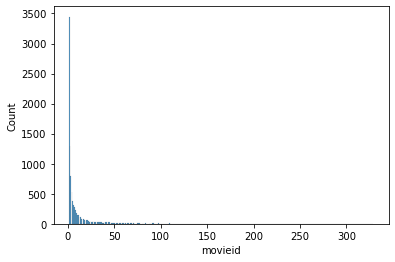

In [27]:
sns.histplot(df_ratings['movieid'].value_counts());

There is a long tail in movies that aren't rate, that's where a recommendation system can shine

Movie breakdown by genre

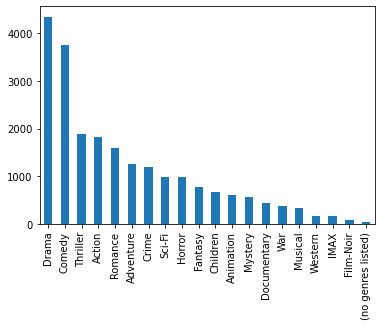

In [28]:
data = df_movies_clean.drop(['movieid', 'title'], axis=1).agg('sum').sort_values(ascending=False)

data.plot.bar();

## Modeling

### Content-Based Model using Cosine Similarity

We'll use the genres and tags to create a content-based model using cosine similarity

In [29]:
# Imports required libraries for the model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
df_movies_clean

,movieid,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9715,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9716,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9717,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_tags_clean

,movieid,"""artsy""",06 oscar nominated best movie - animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,183611,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,184471,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,187593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,187595,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Concatenates the two dataframes to create a new dataframe with all the features
df_features = pd.concat([df_movies_clean, df_tags_clean], axis=1, join='inner')
df_features.drop(['title', '(no genres listed)'], axis=1, inplace=True)

In [82]:
df_features

,movieid,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,world war i,world war ii,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies,zooey deschanel
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,2106,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1568,2107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,2108,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1570,2109,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# Computes cosine similarity matrix using the dataframe with all the features
similarity_matrix = cosine_similarity(df_features)

Generating Recommendations:
Here we show an example of how the content-based recommendation system works. We will use the movie "Toy Story" (movieid 1) as an example. We can see that the model recommends other movies that are similar to Toy Story.

In [84]:
# Assuming you want to recommend movies to a user based on a target movie they have already watched. For example, the user has watched movie 1 and you want to recommend similar movies to them.
target_movie = 0

# Computes the similarity scores between the target movie and all other movies
movie_similarities = similarity_matrix[target_movie]

In [85]:
movie_similarities

array([1.        , 0.52174919, 0.43082022, ..., 0.29190211, 0.2919036 ,
       0.29180606])

In [86]:
# Sorts movie_similarity in descending order
similar_movie_indices = 

In [87]:
similar_movie_indices

array([   0,    1,    2, ..., 1570, 1569, 1571], dtype=int64)

In [73]:
# Get the indices of the most similar movies from movie_similarities
similar_movie_indices = 

In [74]:
similar_movie_indices

array([   1,    2,    4, ..., 1570, 1569, 1571], dtype=int64)

In [ ]:
# Generate Top 5 recommendations based on the most similar users, excluding the target itself
top_5_recommendations = most_similar_movie_ids[2:7]  # Exclude the target user itself
# Uses top_5_recommendations to get the movie titles in the order of recommendations
df_movies_clean[df_movies_clean['movieid'].isin(top_5_recommendations)]['title']


### Collaborative Filtering

We'll start by using the surprise library to build a collaborative filtering model here.

In [37]:
# Imports required libraries for the model
import surprise
from surprise.prediction_algorithms import *
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

In [38]:
df_ratings_clean = df_ratings
df_ratings_clean.columns = df_ratings_clean.columns.str.lower()
df_ratings_clean = df_ratings_clean.drop('timestamp', axis=1)
df_ratings_clean.head()

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


We should only keep ratings for movies that we have genre data for

In [39]:
df_ratings_clean = df_ratings_clean[df_ratings_clean['movieid'].isin(df_movies_clean.movieid)].reset_index(drop=True)
df_ratings_clean

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100825,610,166534,4.0
100826,610,168248,5.0
100827,610,168250,5.0
100828,610,168252,5.0


In [40]:
# Load data
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_ratings_clean[['userid', 'movieid', 'rating']], reader)

In [41]:
# Split data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

In [42]:
# Choose an algorithm and train the model
model1 = KNNBasic()
model1.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [43]:
# Creates a list of all the algorithms we want to test
models = [KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), SVD(), SVDpp(), NMF(), SlopeOne(), CoClustering()]
# Creates a model using each algorithm in models and appends it to a list
for model in models:
    model.fit(trainset)
    # Predicts the ratings for the testset
    predictions = model.test(testset)
    # Calculates the RMSE for each model
    print(f"{model.__class__.__name__}: Test Set RMSE = {rmse(predictions)}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9478
KNNBasic: Test Set RMSE = 0.9477528452003791
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8999
KNNWithMeans: Test Set RMSE = 0.899910651054593
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9001
KNNWithZScore: Test Set RMSE = 0.9000987808020312
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8767
KNNBaseline: Test Set RMSE = 0.876716172337427
RMSE: 0.8705
SVD: Test Set RMSE = 0.870505950085462
RMSE: 0.8577
SVDpp: Test Set RMSE = 0.8577334294930002
RMSE: 0.9216
NMF: Test Set RMSE = 0.9215626919900667
RMSE: 0.9030
SlopeOne: Test Set RMSE = 0.9030435890058635
RMSE: 0.9544
CoClustering: Test Set RMSE = 0.9543880445729948


KNNBasic Appears to be the best model to use here

Generating Recommendations Using our top model

In [44]:
df_ratings_clean[df_ratings_clean['userid'] == 1]

,userid,movieid,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
227,1,3744,4.0
228,1,3793,5.0
229,1,3809,4.0
230,1,4006,4.0


In [45]:
# Make a list of all movie ids based on their predicted rating for a given user(ex. user 1)
user_ratings = df_ratings_clean[df_ratings_clean['userid'] == 1]
pred_ratings = []
for movie_id in user_ratings['movieid']:
    prediction = algo.predict(1, movie_id)
    pred_ratings.append(prediction.est)
    print(f"User {1} might rate movie {movie_id} with a predicted rating of {prediction.est}")

NameError: name 'algo' is not defined